This notebook is created to compare teh first model with this one. Here some data preprocessing techniques will be applied to the images to see whether this imporves the models performance. 

In [14]:
from os import listdir
from numpy import asarray
from keras.preprocessing.image import img_to_array, load_img
from numpy import savez_compressed
from keras import backend as K
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [34]:
# Function to load all images in a directory into memory
def load_images(path, size=(256, 256)):
    data_list = list()
    # Enumerate filenames in directory, assuming all are images
    for filename in listdir(path):
        # Load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # Convert to numpy array
        pixels = np.asarray(pixels)
        
        # Store
        data_list.append(pixels)
    return asarray(data_list)

# Dataset path
path = '/Users/serraus/Desktop/gan-dataset'
monet_data = load_images(path + '/monet_jpg/')
print('Loaded monet_data:', monet_data.shape)

photo_data = load_images(path + '/photo_jpg/')
print('Loaded photo_data:', photo_data.shape)

Loaded monet_data: (300, 256, 256, 3)
Loaded photo_data: (3519, 256, 256, 3)


In [6]:
print(monet_data[1])

[[[  4   4   2]
  [  2   2   0]
  [  0   0   0]
  ...
  [  0   3   5]
  [  0   5   8]
  [ 11  19  22]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  5  13  15]
  [  9  17  20]
  [ 25  33  36]]

 [[  0   2   0]
  [  0   2   0]
  [  1   3   0]
  ...
  [  0   6   8]
  [  2  10  13]
  [ 18  26  29]]

 ...

 [[107 110  79]
  [ 90  93  62]
  [ 82  86  53]
  ...
  [215 200 141]
  [225 210 151]
  [224 209 150]]

 [[ 95 101  67]
  [ 84  90  56]
  [ 84  90  56]
  ...
  [220 208 150]
  [226 214 156]
  [224 212 154]]

 [[ 76  82  48]
  [ 59  65  31]
  [ 53  59  25]
  ...
  [248 238 179]
  [248 238 179]
  [243 233 174]]]


Some data augmentation will be applied to produce more Monet style images since there are only 300 of them compared to 7038 images. Methods that are not too rough will be selected since the original form and style of Monet needs to be preserved. 

Method 1 -> Random crops from images:

In [10]:
output_file_path = "/Users/serraus/Documents/GitHub/ML_Project_Generative_Adversarial_Network/GAN_Project/cropped_images"
num_crops_per_image = 4
crop_width = 192
crop_height = 192
for filename in os.listdir(path + '/monet_jpg/'):
    if filename.endswith(".jpg"):
        image_path = os.path.join(path + '/monet_jpg/', filename)
        
        # Open the image using PIL
        image = Image.open(image_path)
        
        # Get the dimensions of the image
        width, height = image.size

        for i in range(num_crops_per_image):
            left = np.random.randint(0, (width - crop_width)) #x of left up&down corner 
            right = left + crop_width #x of right up&down corner 
            up = np.random.randint(0, (height - crop_height)) #y
            down = up + crop_height #y

            cropped_image = image.crop((left, up, right, down))
            
            # Save the cropped image to the output directory
            cropped_filename = f"{os.path.splitext(filename)[0]}_crop_{i}.jpg"
            cropped_path = os.path.join(output_file_path, cropped_filename)
            cropped_image.save(cropped_path)

print("Random cropping and saving complete.")
        


Random cropping and saving complete.


In [12]:
import os

folder_path = '/Users/serraus/Documents/GitHub/ML_Project_Generative_Adversarial_Network/GAN_Project/cropped_images'  # Replace this with the actual path to your folder

# List all items (files and subfolders) in the folder
items = os.listdir(folder_path)

# Count only files (excluding subfolders)
file_count = sum(1 for item in items if os.path.isfile(os.path.join(folder_path, item)))

print("Number of files:", file_count)


Number of files: 1200


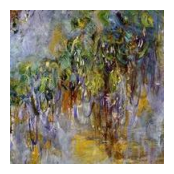

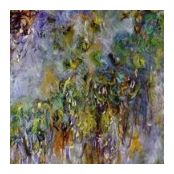

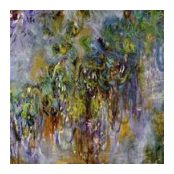

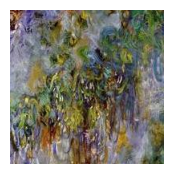

In [15]:
image1 = '/Users/serraus/Documents/GitHub/ML_Project_Generative_Adversarial_Network/GAN_Project/cropped_images/0a5075d42a_crop_0.jpg'
image2 = '/Users/serraus/Documents/GitHub/ML_Project_Generative_Adversarial_Network/GAN_Project/cropped_images/0a5075d42a_crop_1.jpg'
image3 = '/Users/serraus/Documents/GitHub/ML_Project_Generative_Adversarial_Network/GAN_Project/cropped_images/0a5075d42a_crop_2.jpg'
image4 = '/Users/serraus/Documents/GitHub/ML_Project_Generative_Adversarial_Network/GAN_Project/cropped_images/0a5075d42a_crop_3.jpg'
new_images = [image1, image2, image3, image4]
for image in new_images:
    img = Image.open(image)
    plt.figure(figsize=(2, 2))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

The new images created seem to have small differences while preserving Monets style. This will provide the model with more examples to learn from where the examples are assumbed to be not teaching wrong patterns to the model. 

Next step is to apply normalization to the pixel values so that they are all in a certain range which helps the model to learn faster by preventing "exploding gradients" problem.

Method 2 -> Pixel Normalization: 

In [18]:
import os
import numpy as np
from PIL import Image

# Set the path to your image dataset
image_dir = '/Users/serraus/Desktop/gan-dataset/monet_jpg'
# Initialize lists to store pixel values
pixel_values = []

# Iterate through the images in your dataset
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg"):  # Modify the extensions as needed
        image_path = os.path.join(image_dir, filename)
        
        # Open the image using PIL
        image = Image.open(image_path)
        
        # Convert the image to a NumPy array
        image_array = np.array(image)
        
        # Flatten the image array and add it to the list of pixel values
        pixel_values.extend(image_array.flatten())

# Convert the list of pixel values to a NumPy array
pixel_values = np.array(pixel_values)

# Calculate the mean and scaling factor
mean_pixel_value = np.mean(pixel_values)
scaling_factor = 255.0 / 2.0  # Assuming 8-bit images

# Normalize pixel values to the range [-1, 1]
normalized_pixel_values = (pixel_values - mean_pixel_value) / scaling_factor

# Ensure the normalized pixel values are within the range [-1, 1]
normalized_pixel_values = np.clip(normalized_pixel_values, -1.0, 1.0)

# Reshape the normalized pixel values back to the original image shapes
num_images = len(os.listdir(image_dir))
image_shape = (num_images, image_array.size)
normalized_pixel_values = normalized_pixel_values.reshape(image_shape)

# Now, normalized_pixel_values contains the normalized pixel values of your images in the range [-1, 1]


In [17]:
import os
import numpy as np
from PIL import Image

# Set the path to your image dataset
image_dir = '/Users/serraus/Documents/GitHub/ML_Project_Generative_Adversarial_Network/GAN_Project/cropped_images'

# Initialize lists to store pixel values
pixel_values = []

# Iterate through the images in your dataset
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg"):  # Modify the extensions as needed
        image_path = os.path.join(image_dir, filename)
        
        # Open the image using PIL
        image = Image.open(image_path)
        
        # Convert the image to a NumPy array
        image_array = np.array(image)
        
        # Flatten the image array and add it to the list of pixel values
        pixel_values.extend(image_array.flatten())

# Convert the list of pixel values to a NumPy array
pixel_values = np.array(pixel_values)

# Calculate the mean and scaling factor
mean_pixel_value = np.mean(pixel_values)
scaling_factor = 255.0 / 2.0  # Assuming 8-bit images

# Normalize pixel values to the range [-1, 1]
normalized_pixel_values = (pixel_values - mean_pixel_value) / scaling_factor

# Ensure the normalized pixel values are within the range [-1, 1]
normalized_pixel_values = np.clip(normalized_pixel_values, -1.0, 1.0)

# Reshape the normalized pixel values back to the original image shapes
num_images = len(os.listdir(image_dir))
image_shape = (num_images, image_array.size)
normalized_pixel_values = normalized_pixel_values.reshape(image_shape)

# Now, normalized_pixel_values contains the normalized pixel values of your images in the range [-1, 1]


In [16]:
import os
import numpy as np
from PIL import Image

# Set the path to your image dataset
image_dir = '/Users/serraus/Desktop/gan-dataset/photo_jpg'
# Initialize lists to store pixel values
pixel_values = []

# Iterate through the images in your dataset
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg"):  # Modify the extensions as needed
        image_path = os.path.join(image_dir, filename)
        
        # Open the image using PIL
        image = Image.open(image_path)
        
        # Convert the image to a NumPy array
        image_array = np.array(image)
        
        # Flatten the image array and add it to the list of pixel values
        pixel_values.extend(image_array.flatten())

# Convert the list of pixel values to a NumPy array
pixel_values = np.array(pixel_values)

# Calculate the mean and scaling factor
mean_pixel_value = np.mean(pixel_values)
scaling_factor = 255.0 / 2.0  # Assuming 8-bit images

# Normalize pixel values to the range [-1, 1]
normalized_pixel_values = (pixel_values - mean_pixel_value) / scaling_factor

# Ensure the normalized pixel values are within the range [-1, 1]
normalized_pixel_values = np.clip(normalized_pixel_values, -1.0, 1.0)

# Reshape the normalized pixel values back to the original image shapes
num_images = len(os.listdir(image_dir))
image_shape = (num_images, image_array.size)
normalized_pixel_values = normalized_pixel_values.reshape(image_shape)

# Now, normalized_pixel_values contains the normalized pixel values of your images in the range [-1, 1]


In [17]:
import os
import numpy as np
from PIL import Image

# Set the path to your image dataset
image_dir = '/Users/serraus/Desktop/gan-dataset/photo2_jpg'
# Initialize lists to store pixel values
pixel_values = []

# Iterate through the images in your dataset
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg"):  # Modify the extensions as needed
        image_path = os.path.join(image_dir, filename)
        
        # Open the image using PIL
        image = Image.open(image_path)
        
        # Convert the image to a NumPy array
        image_array = np.array(image)
        
        # Flatten the image array and add it to the list of pixel values
        pixel_values.extend(image_array.flatten())

# Convert the list of pixel values to a NumPy array
pixel_values = np.array(pixel_values)

# Calculate the mean and scaling factor
mean_pixel_value = np.mean(pixel_values)
scaling_factor = 255.0 / 2.0  # Assuming 8-bit images

# Normalize pixel values to the range [-1, 1]
normalized_pixel_values = (pixel_values - mean_pixel_value) / scaling_factor

# Ensure the normalized pixel values are within the range [-1, 1]
normalized_pixel_values = np.clip(normalized_pixel_values, -1.0, 1.0)

# Reshape the normalized pixel values back to the original image shapes
num_images = len(os.listdir(image_dir))
image_shape = (num_images, image_array.size)
normalized_pixel_values = normalized_pixel_values.reshape(image_shape)

# Now, normalized_pixel_values contains the normalized pixel values of your images in the range [-1, 1]


Monet images from original data set, cropped Monet images, and phtotos now have pixel values ranging from -1 to 1. This will allow faster learning by reducing the complexity of data and making it consistent.
NOTE: photo_jpg folder was divided into 2 folders so that pixel normalization can be done faster.

Next step is to convert the size of cropped monet images back to 256x256 so that data is consistent. 

In [28]:
input_images = '/Users/serraus/Documents/GitHub/ML_Project_Generative_Adversarial_Network/GAN_Project/cropped_images'
output_images = '/Users/serraus/Desktop/gan-dataset/monet_cropped_jpg'
new_size = (256, 256)

if not os.path.exists(output_images):
    os.makedirs(output_images)

images = [i for i in os.listdir(input_images) if i.endswith('.jpg')]
for image_file in images: 
    input_path = os.path.join(input_images, image_file)
    output_path = os.path.join(output_images, image_file)

    image = Image.open(input_path)
    resized_image = image.resize(new_size)
    resized_image.save(output_path)
print("All images resized and saved")

All images resized and saved


In [33]:
def load_images(path, size=(256, 256)):
    data_list = list()
    # Enumerate filenames in directory, assuming all are images
    for filename in listdir(path):
        # Load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # Convert to numpy array
        pixels = np.asarray(pixels)
        
        # Store
        data_list.append(pixels)
    return asarray(data_list)

# Dataset path
path = '/Users/serraus/Desktop/gan-dataset' 
cropped_monet_data = load_images(path + '/monet_cropped_jpg/')
print('Loaded cropped_monet_data:', cropped_monet_data.shape)

photo2_data = load_images(path + '/photo2_jpg/')
print('Loaded photo2_data:', photo2_data.shape)

Loaded cropped_monet_data: (1200, 256, 256, 3)
Loaded photo2_data: (3519, 256, 256, 3)


When Monet paintings are examined it is very clear that he worked with color, reflections, different light conditions etc. Therefore another data augmentation technique, which is playing with colors of the images will not be applied since one of the defining features of Monet paintings is his use of light and colors according to the shades of light.  